/tmp/ipykernel_9115/4073705137.py:144: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


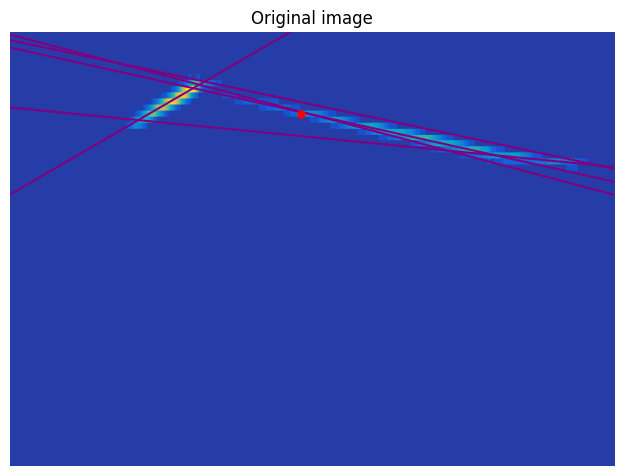

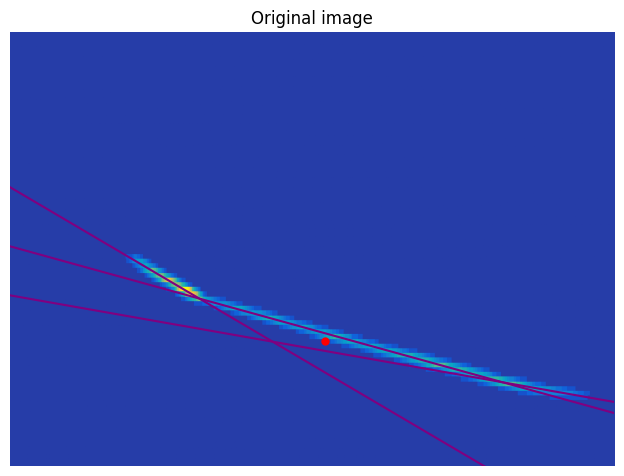

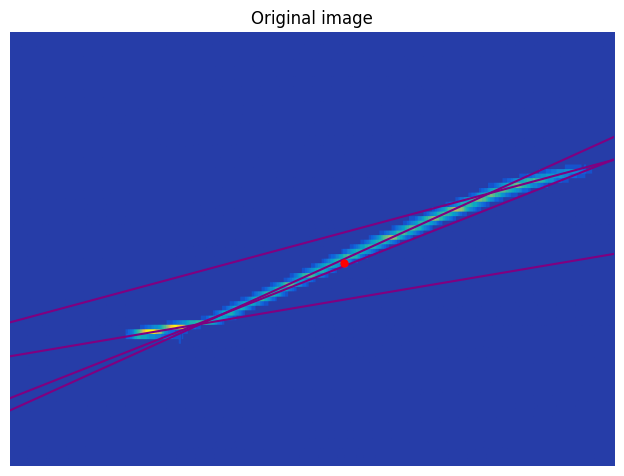

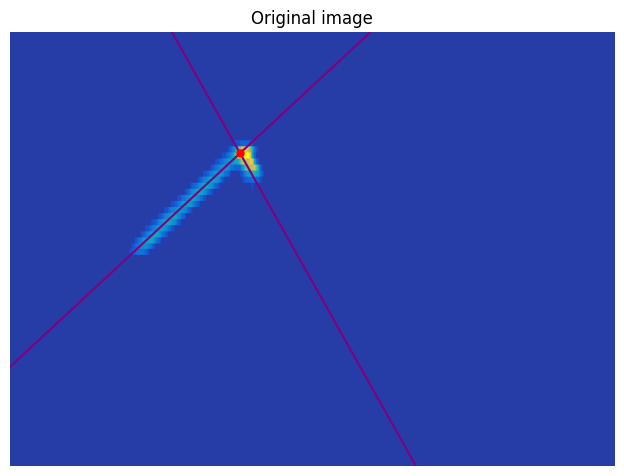

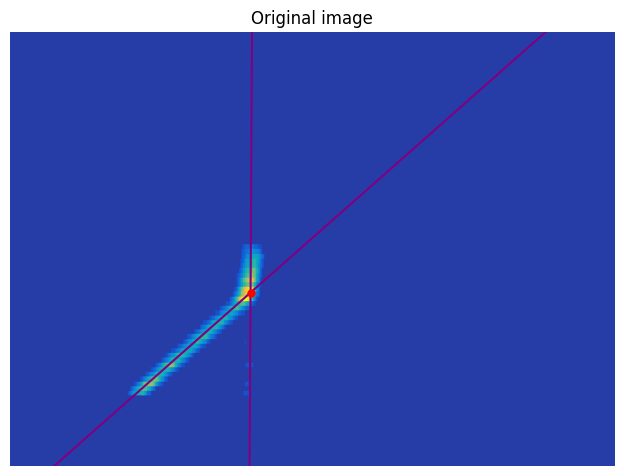

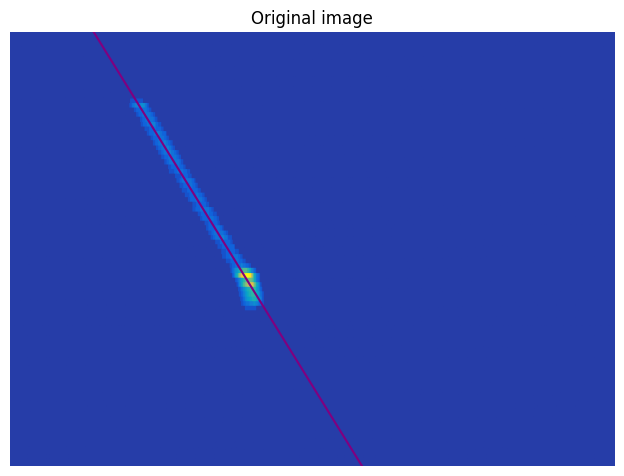

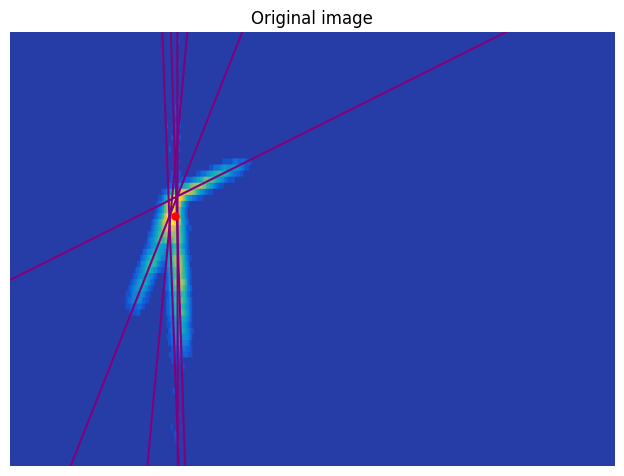

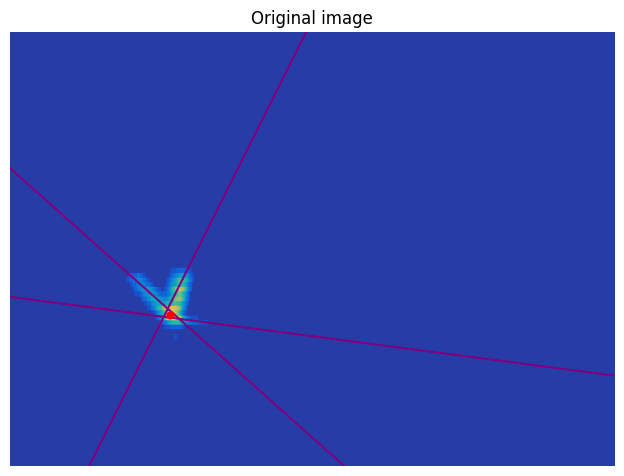

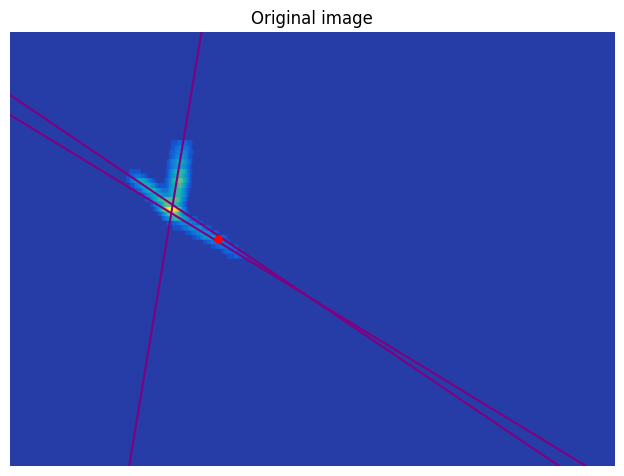

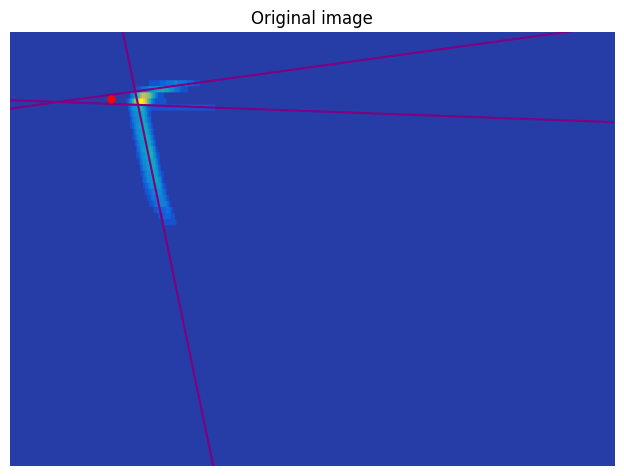

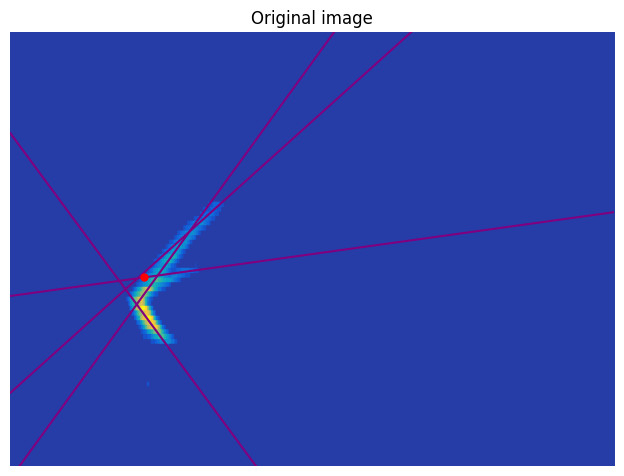

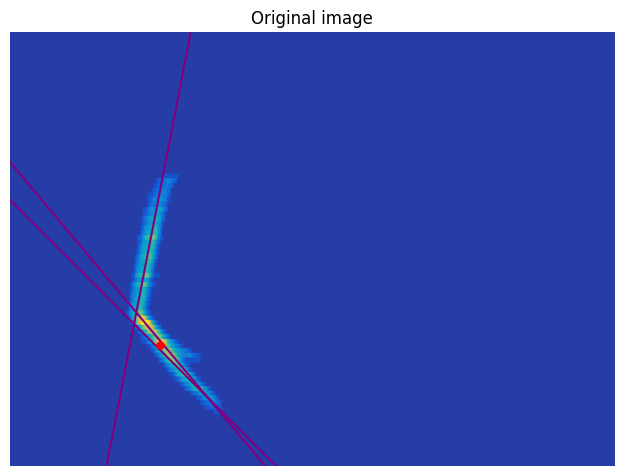

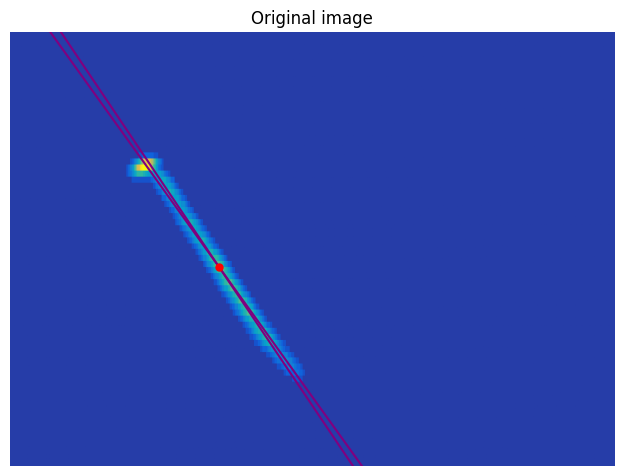

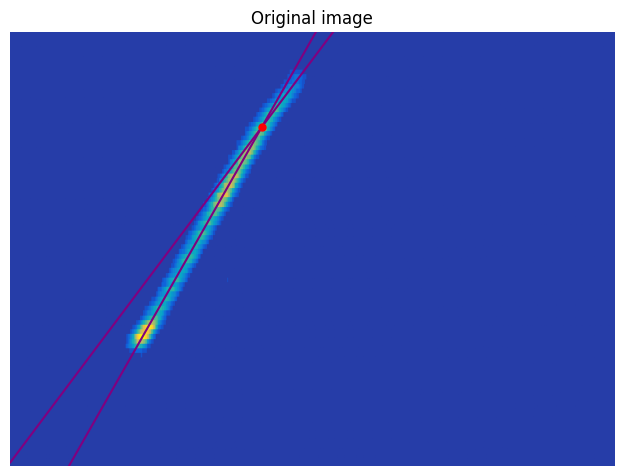

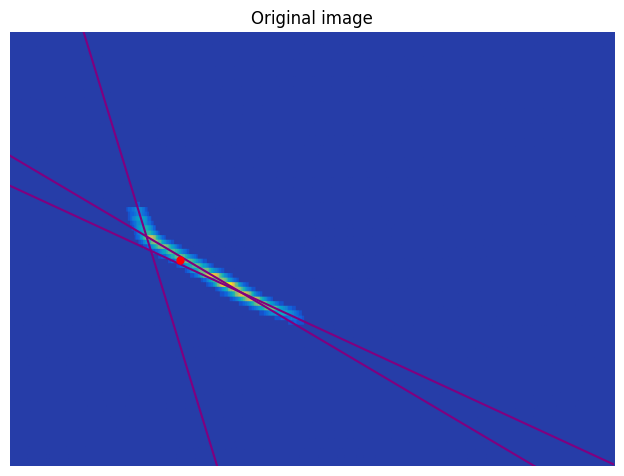

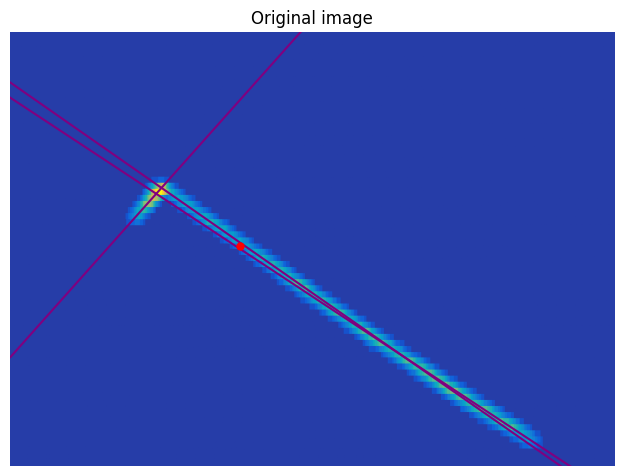

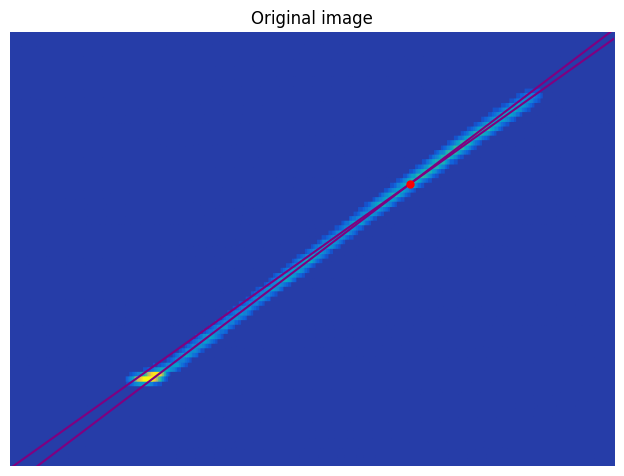

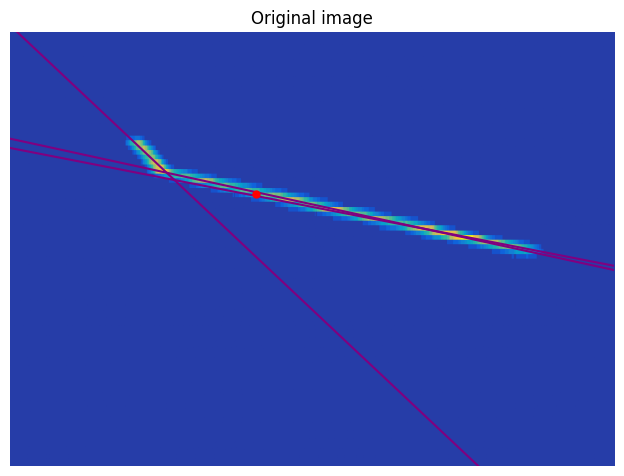

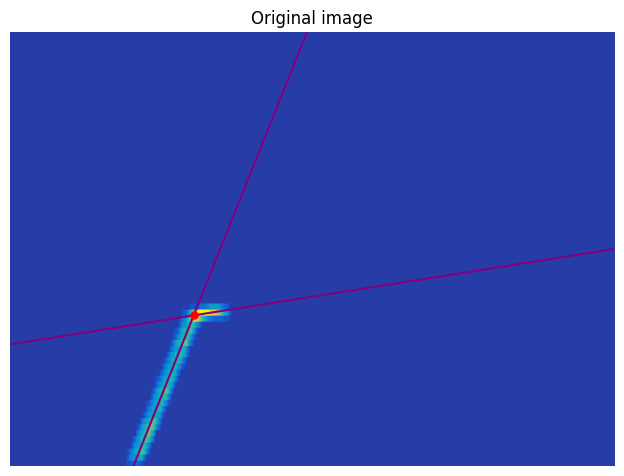

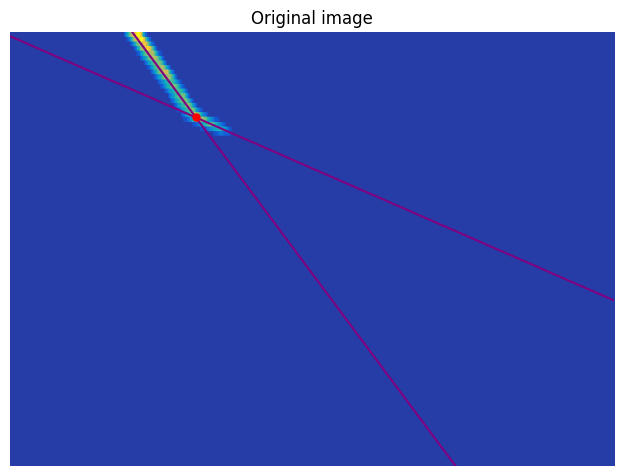

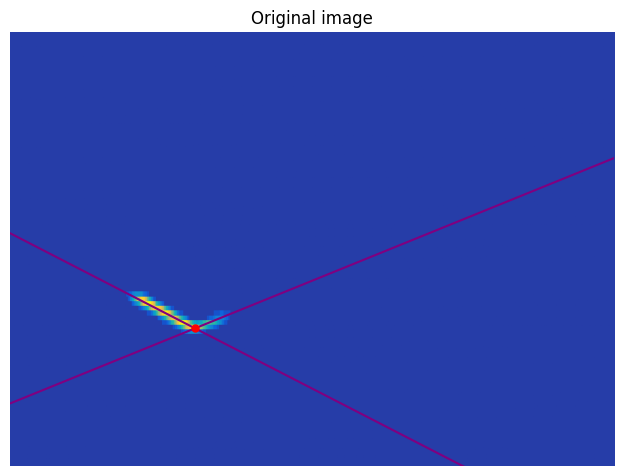

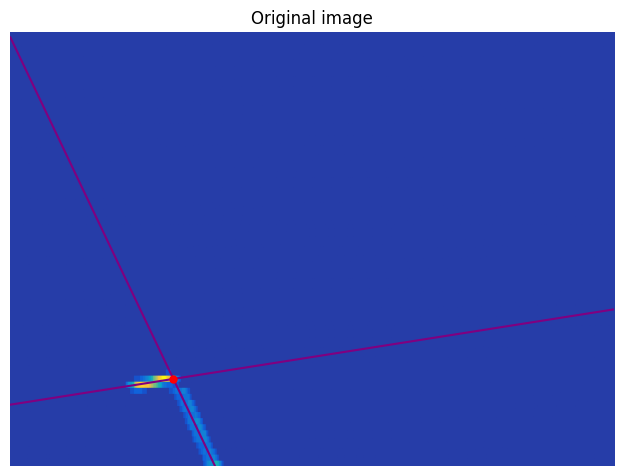

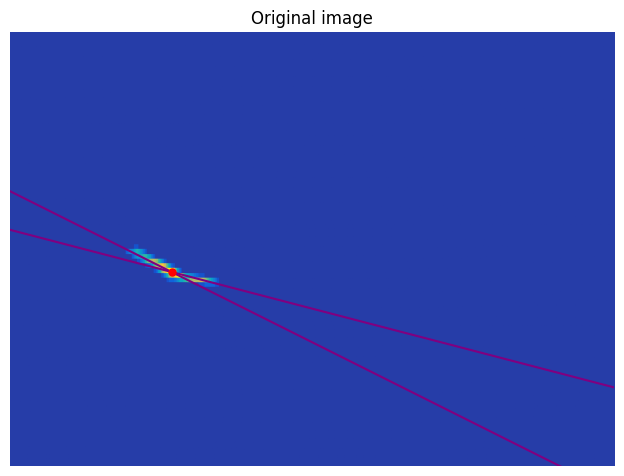

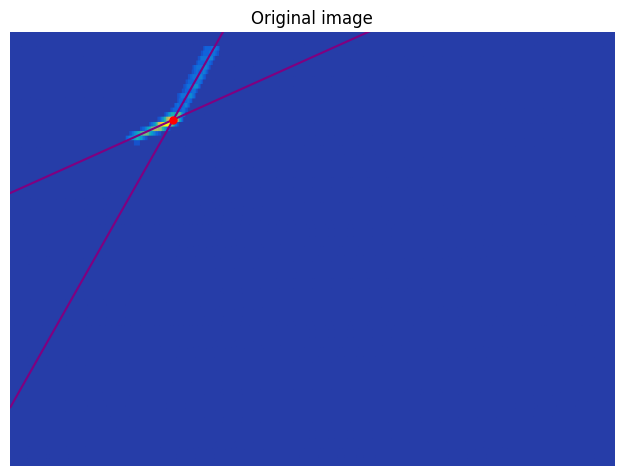

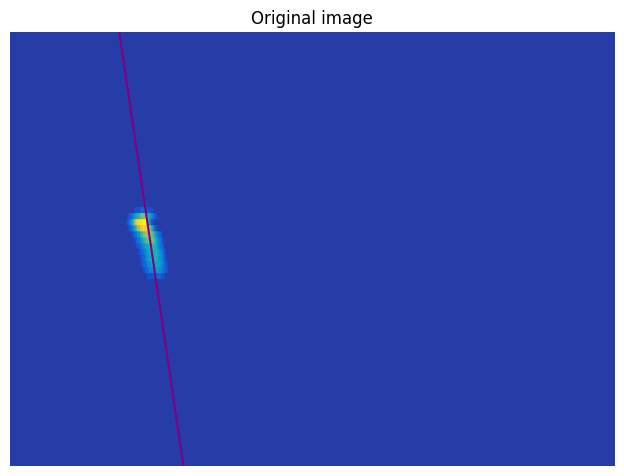

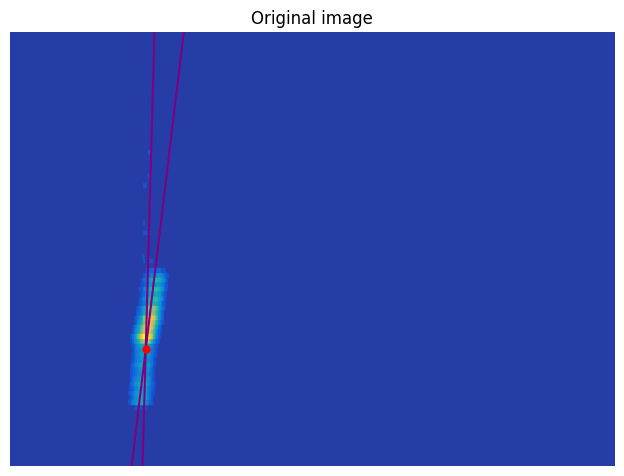

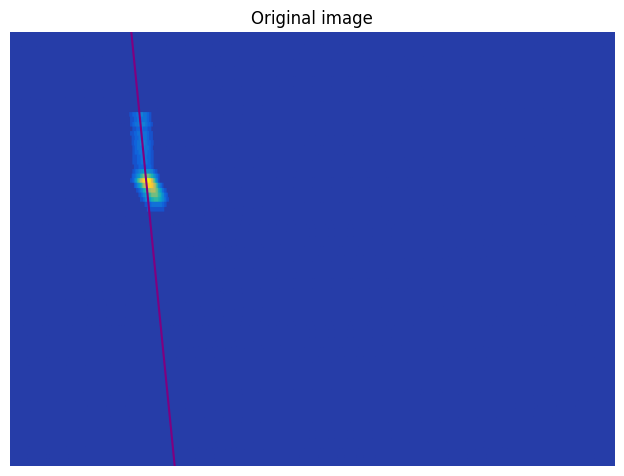

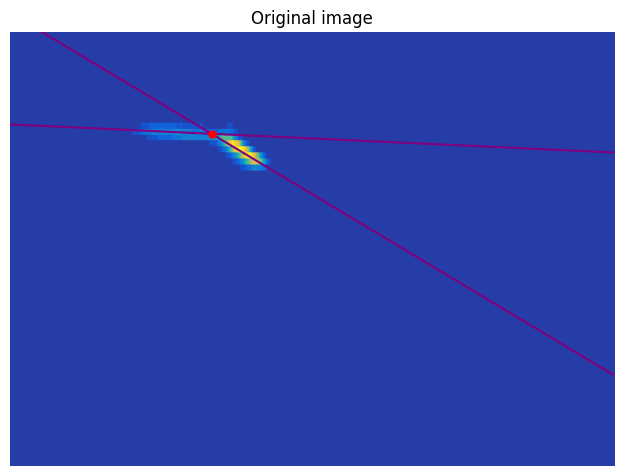

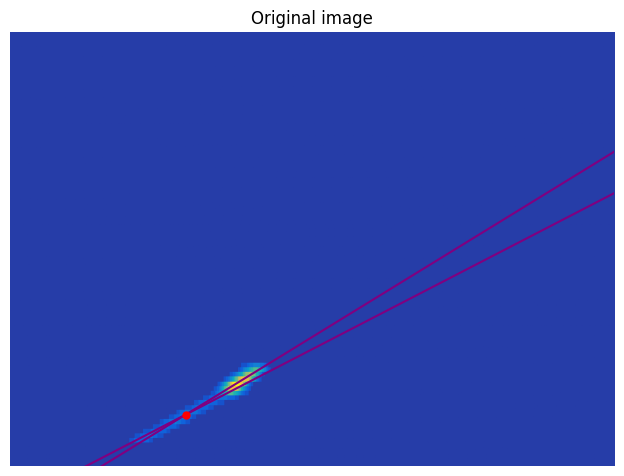

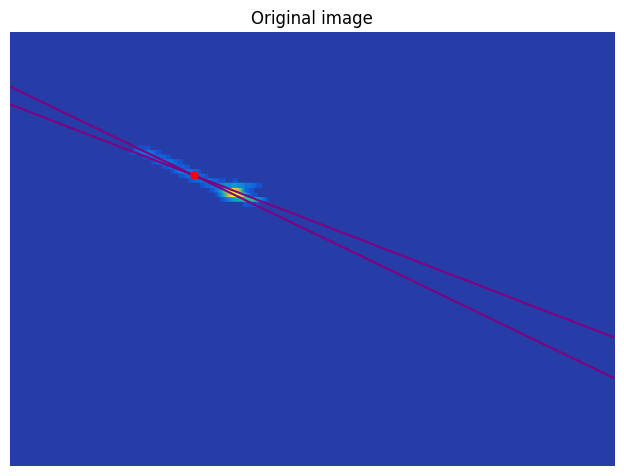

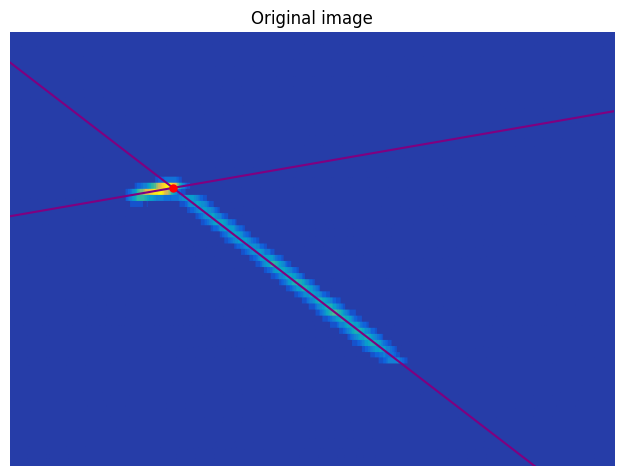

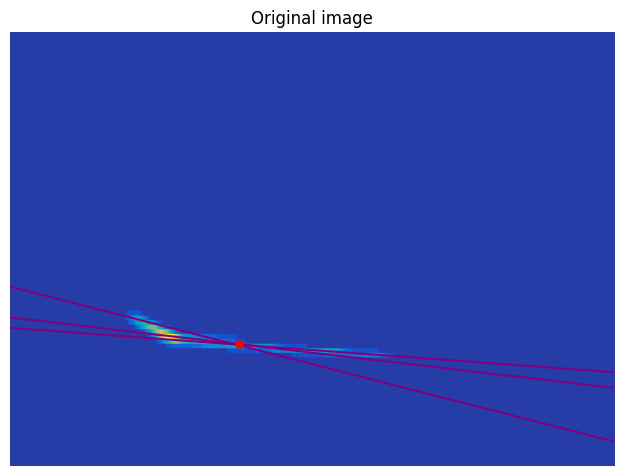

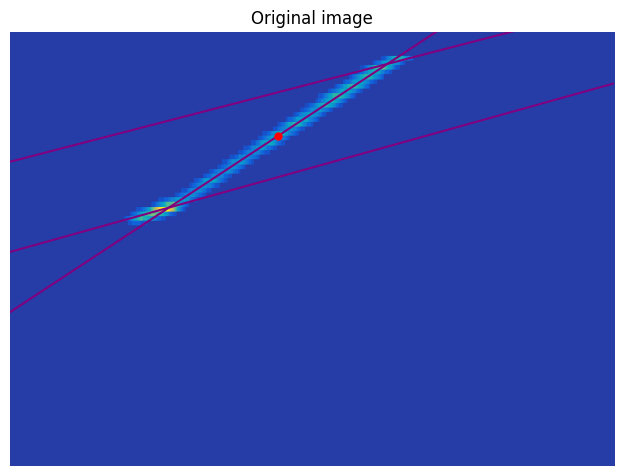

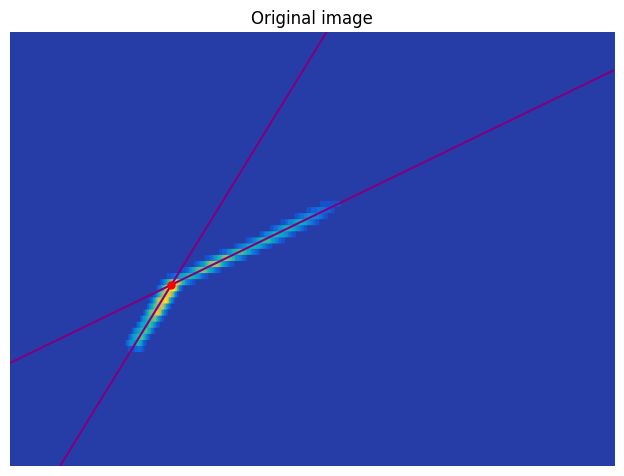

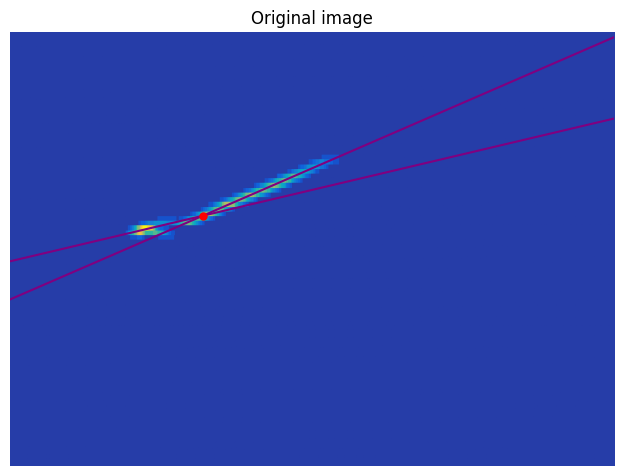

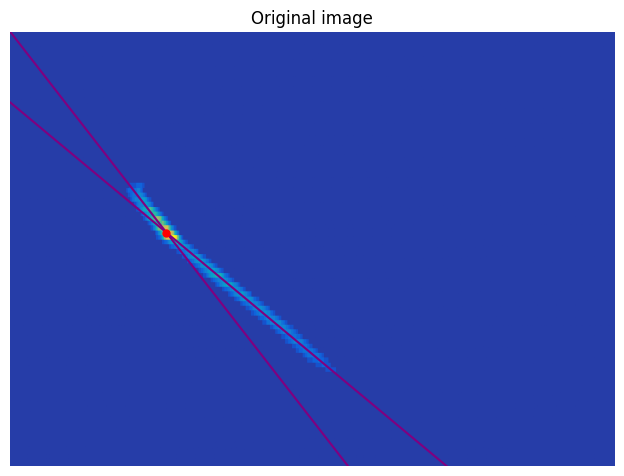

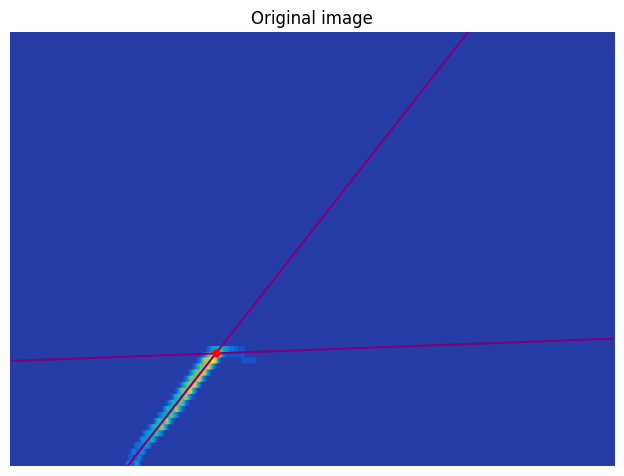

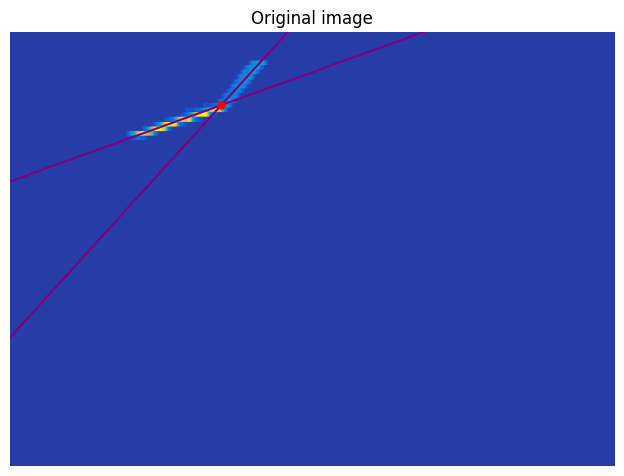

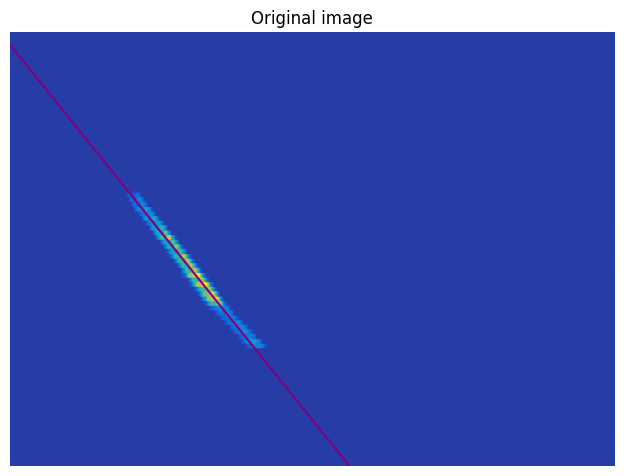

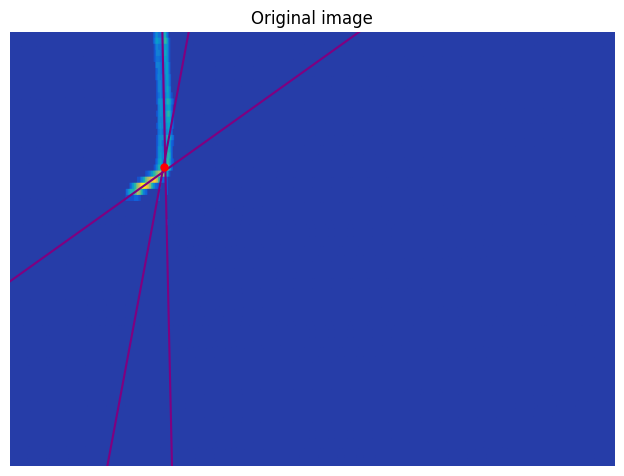

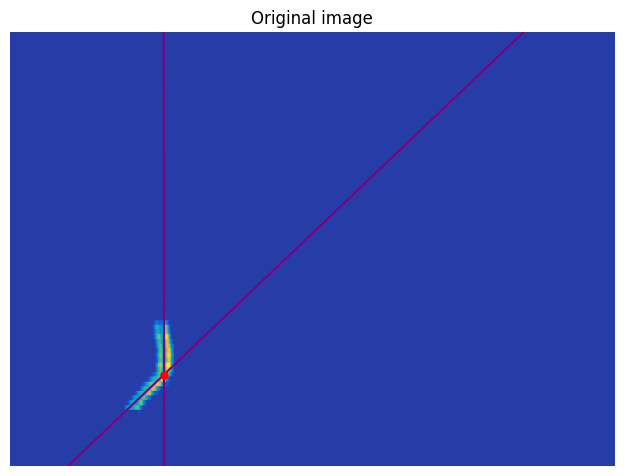

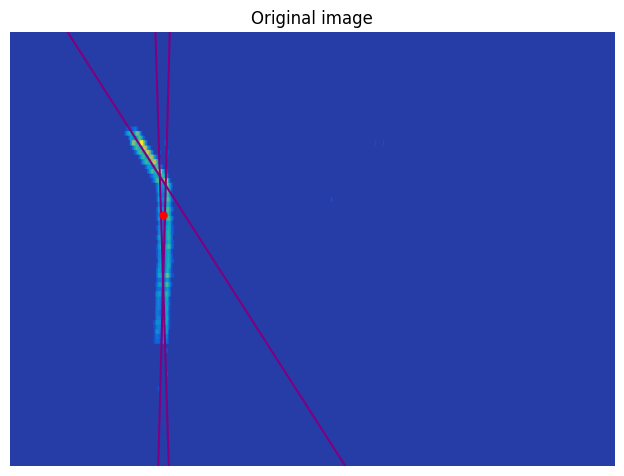

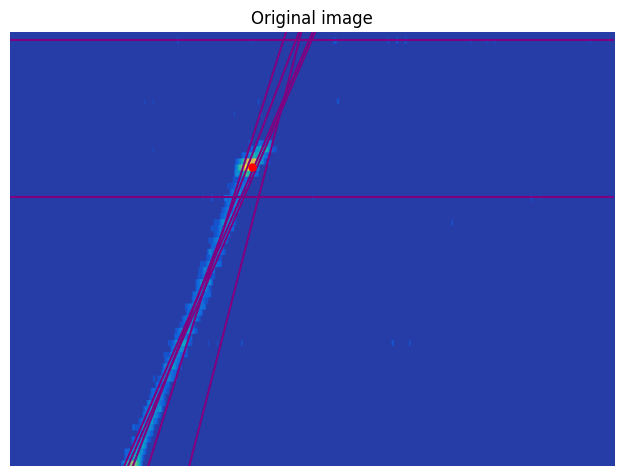

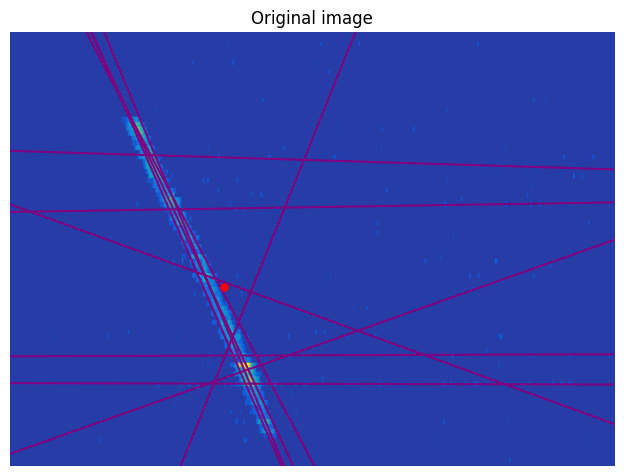

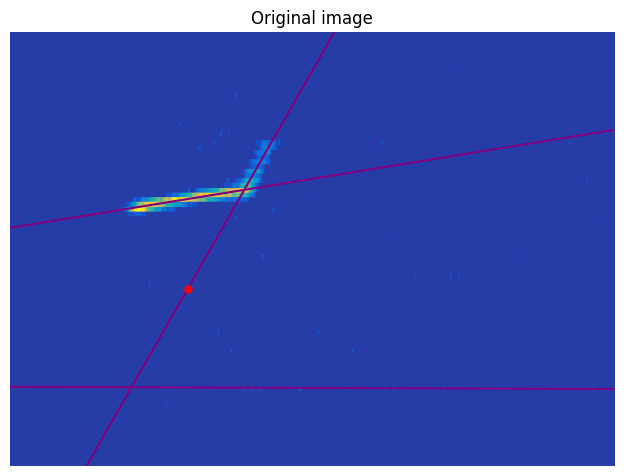

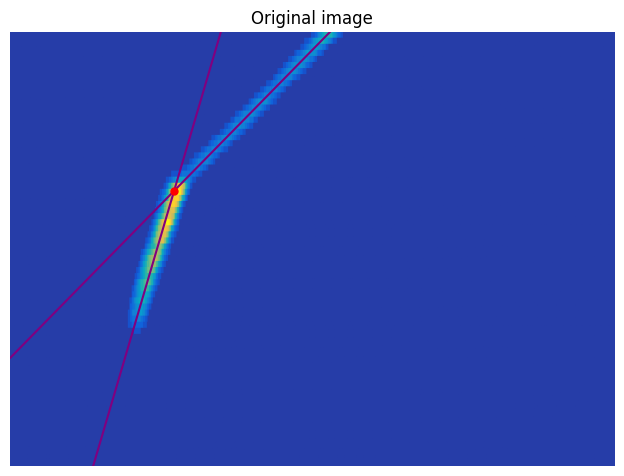

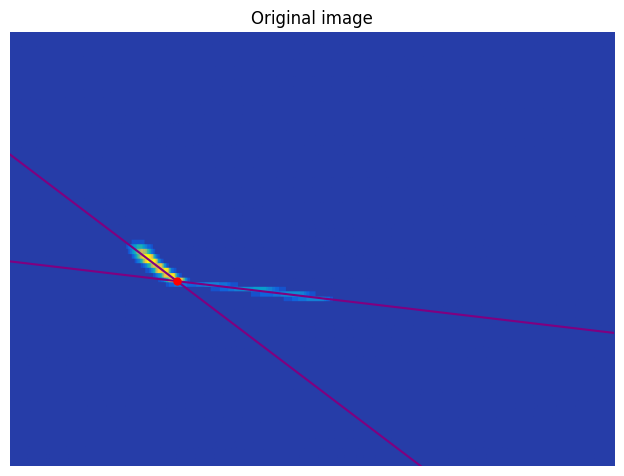

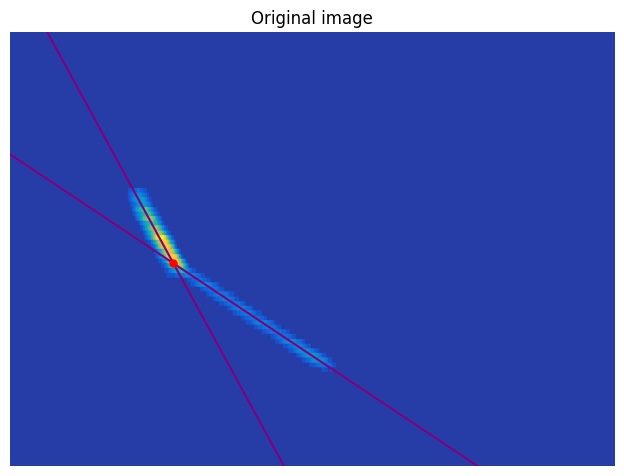

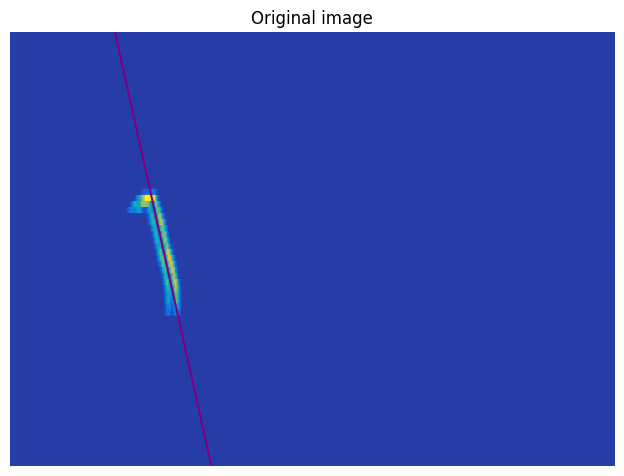

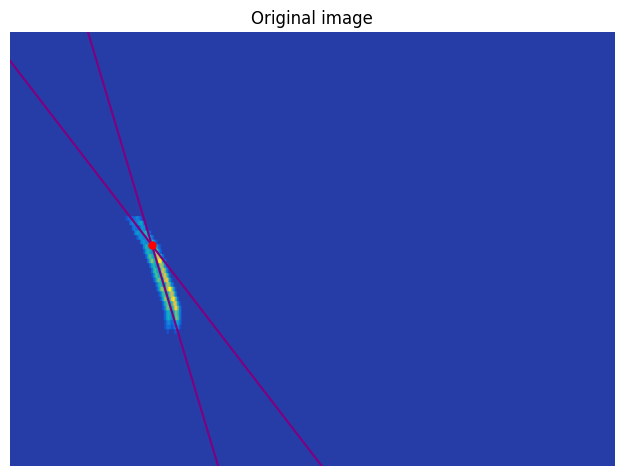

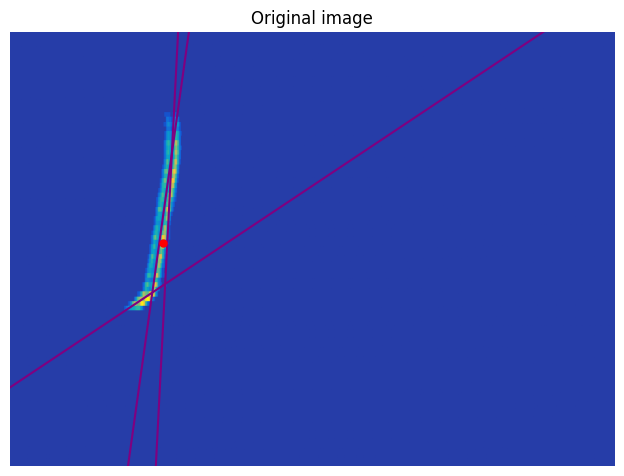

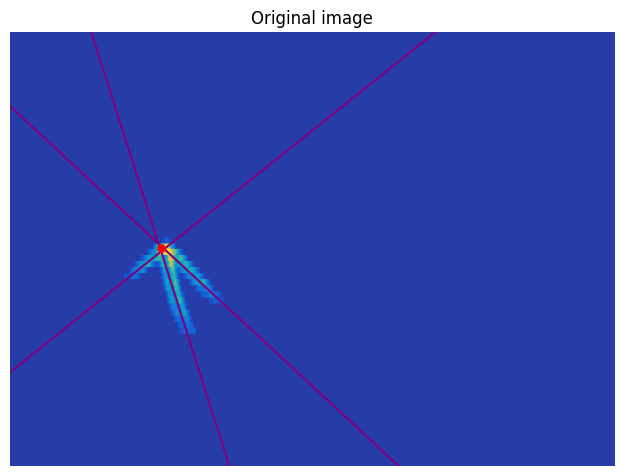

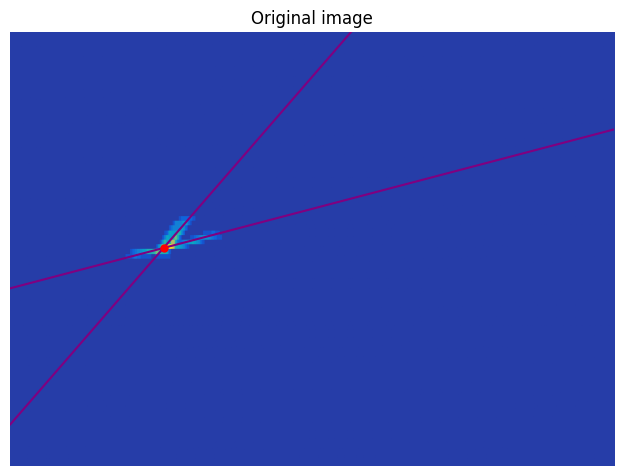

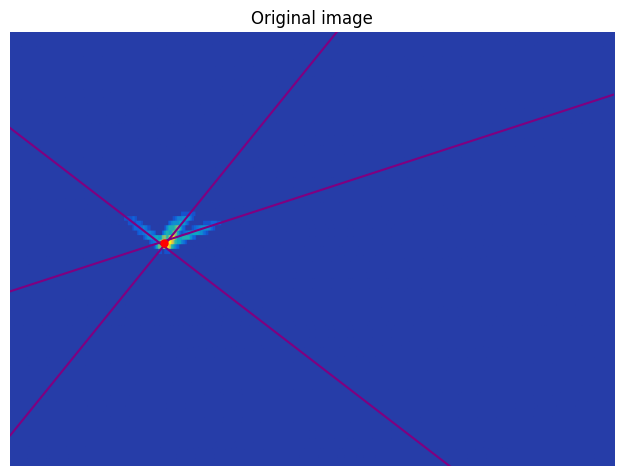

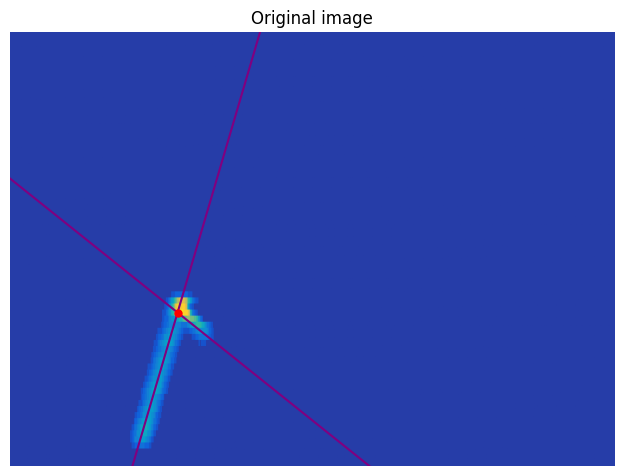

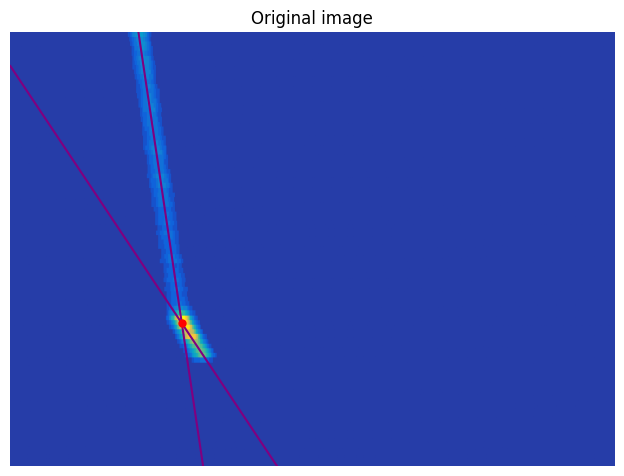

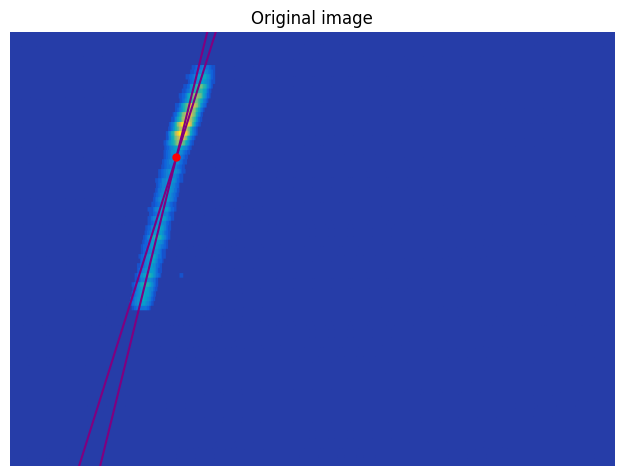

In [8]:
from wolframclient.language.expression import WLFunction
from wolframclient.serializers import export
from wolframclient.language import wl, wlexpr
from wolframclient.evaluation import WolframLanguageSession
from matplotlib import cm
import math
import numpy as np
import matplotlib.pyplot as plt
from openImage import openImage
import sys
import os
sys.path.append("/home/gant/Documents/tpcanalysis/python_comp/src")


def fitImage(session, path_and_name_input, path_and_name_output, draw_opt=True, lines_th=0.01, max_features=0):

    # Evaluate the expressions
    session.evaluate(f'img = Import["{path_and_name_input}"];')
    session.evaluate('whiteth = 0.3;')
    session.evaluate('bwimage = Binarize[img, whiteth];')
    session.evaluate('bwimage = Thinning[bwimage];')

    if (max_features == 0):
        session.evaluate(
            f'lines = ImageLines[bwimage, {lines_th}, Method -> "RANSAC"];')
    else:
        session.evaluate(
            f'lines = ImageLines[bwimage, {lines_th}, Method -> "RANSAC", MaxFeatures -> {max_features}];')

    # Draw and export if option is chosen
    if (draw_opt):
        session.evaluate('highlightedimage = HighlightImage[bwimage, lines];')
        session.evaluate(
            'highlightedimageoriginal = HighlightImage[img, lines]')
        # session.evaluate('Export["{}", highlightedimage];'.format(path_and_name_output))
        session.evaluate(
            f'Export["{path_and_name_output}", highlightedimageoriginal];')

    # Calculate slopes and intercepts
    """ session.evaluate('slopes = Table[(lines[[i, 1, 2, 2]] - lines[[i, 1, 1, 2]])/(lines[[i, 1, 2, 1]] - lines[[i, 1, 1, 1]]), {i, 1, Length[lines]}];')
    session.evaluate('intercepts = Table[lines[[i, 1, 1, 2]] - slopes[[i]]*lines[[i, 1, 1, 1]], {i, 1, Length[lines]}];')
    
    slopes = session.evaluate('slopes')
    intercepts = session.evaluate('intercepts')
    equations = list(zip(slopes, intercepts))

    #Change DirectedInfinity[] to float('inf') when the slope is infinite.
    equations = [(slope, intercept) if not isinstance(slope, WLFunction) and not isinstance(intercept, WLFunction) else (float('inf'), float('inf')) for slope, intercept in equations]

    return equations """

    # Simpler to just use the segments and manipulate them in Python.
    # Python is simpler.
    session.evaluate('x1 = Table[lines[[i, 1, 1, 1]], {i, 1, Length[lines]}]')
    session.evaluate('y1 = Table[lines[[i, 1, 1, 2]], {i, 1, Length[lines]}]')
    session.evaluate('x2 = Table[lines[[i, 1, 2, 1]], {i, 1, Length[lines]}]')
    session.evaluate('y2 = Table[lines[[i, 1, 2, 2]], {i, 1, Length[lines]}]')
    x1 = session.evaluate('x1')
    y1 = session.evaluate('y1')
    x2 = session.evaluate('x2')
    y2 = session.evaluate('y2')

    lines = list(zip(zip(x1, y1), zip(x2, y2)))

    return lines


def findLinesEquation(lines):

    lines_eq = []

    for line in lines:

        # Extract the coordinates for the two points of the line
        (x1, y1), (x2, y2) = line

        if ((x2 - x1) != 0):

            # Calculate the slope
            slope = (y2 - y1) / (x2 - x1)

            # Calculate the intercept
            intercept = y1 - slope * x1
        else:
            # Good enough for now
            slope = 999
            intercept = y1 - slope * x1

        lines_eq.append([slope, intercept])

    return lines_eq


def findInteractionPoint(lines):

    lines_eq = findLinesEquation(lines)

    intersections = []

    for i, (slope1, intercept1) in enumerate(lines_eq):
        for slope2, intercept2 in lines_eq[i + 1:]:
            if slope1 != slope2:  # Lines are not parallel
                x = (intercept2 - intercept1) / (slope1 - slope2)
                y = slope1 * x + intercept1
                if (x > 0 and x < 800 and y > 0 and y < 600):
                    intersections.append((x, y))

    if (len(intersections) == 0):
        raise ValueError("No intersection points found.")

    average_x = sum(
        map(lambda point: point[0], intersections)) / len(intersections)
    average_y = sum(
        map(lambda point: point[1], intersections)) / len(intersections)

    return [average_x, average_y]


def drawInteractionPoint(lines, path_and_name_input, path_and_name_output, plot_title='Original image'):

    test_image = openImage(path_and_name_input)
    test_image.readImage()

    test_image.m_data = np.flipud(test_image.m_data)

    fig = plt.figure()

    plt.imshow(test_image.m_data)
    plt.title(plot_title)
    plt.ylim((test_image.m_data.shape[0], 0))
    plt.axis('off')

    lines_eq = findLinesEquation(lines)

    for slope, intercept in lines_eq:

        x = np.arange(0, test_image.m_data.shape[1])
        y = slope * x + intercept

        plt.plot(x, y, label="fitted line", color='purple')

    try:

        average_x, average_y = findInteractionPoint(lines)

        plt.plot(average_x, average_y, marker='o', markersize=5, color='red')

    except ValueError as e:
        pass

    plt.tight_layout()
    # plt.show()
    plt.savefig(path_and_name_output)


def findPolarCoordinates(lines):
    # Takes in lines in the format (x1, y1), (x2, y2) = line and returns
    # the polar coordinates [angle, distance].

    lines_eq = []

    for line in lines:

        (x1, y1), (x2, y2) = line

        # Calculate differences
        dx = x2 - x1
        dy = y2 - y1

        # Calculate polar coordinates
        angle = math.atan2(dy, dx)
        distance = math.hypot(dx, dy)

        # Convert angle to degrees
        # angle_degrees = math.degrees(angle)

        lines_eq.append([angle, distance])

    return lines_eq


# Make sure the dirs exist befoe calling the function. Don't have time to make sure in code.
image_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages2/"

image_list = ["CoBo_2018-06-20T10-51-39.459_0000/25",
              "CoBo_2018-06-20T10-51-39.459_0002/511",
              "CoBo_2018-06-20T10-51-39.459_0002/672",
              "CoBo_2018-06-20T10-51-39.459_0002/1019",
              "CoBo_2018-06-20T10-51-39.459_0003/1319",
              "CoBo_2018-06-20T10-51-39.459_0003/1428",
              "CoBo_2018-06-20T10-51-39.459_0004/114",
              "CoBo_2018-06-20T10-51-39.459_0004/319",
              "CoBo_2018-06-20T10-51-39.459_0004/417",
              "CoBo_2018-06-20T10-51-39.459_0004/448",
              "CoBo_2018-06-20T10-51-39.459_0004/1456",
              "CoBo_2018-06-20T10-51-39.459_0004/1596",
              "CoBo_2018-06-20T10-51-39.459_0004/1725",
              "CoBo_2018-06-20T10-51-39.459_0005/477",
              "CoBo_2018-06-20T10-51-39.459_0005/677",
              "CoBo_2018-06-20T10-51-39.459_0005/1113",
              "CoBo_2018-06-20T10-51-39.459_0005/1190",
              "CoBo_2018-06-20T10-51-39.459_0005/1311",
              "CoBo_2018-06-20T10-51-39.459_0005/1843"]

image_suffix_list = ["_u.png", "_v.png", "_w.png"]


output_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/fittedimages/"

number_of_lines = [2, 2, 2,  # 0
                   2, 2, 2,  # 2
                   3, 3, 3,
                   3, 3, 3,
                   2, 2, 2,  # 3
                   2, 2, 2,
                   2, 2, 2,  # 4
                   2, 2, 2,
                   2, 2, 2,
                   2, 2, 2,
                   2, 2, 2,
                   2, 2, 2,
                   2, 2, 2,
                   2, 2, 2,  # 5
                   2, 2, 2,
                   2, 2, 2,
                   2, 2, 2,
                   3, 3, 3,
                   2, 2, 2]

session = WolframLanguageSession()


try:
    # Evaluate the expressions
    """ session.evaluate('img = Import["{}"];'.format("/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages/CoBo_2018-06-20T10-51-39.459_0000/25_u.png"))
    session.evaluate('whiteth = 0.3;')
    session.evaluate('bwimage = Binarize[img, whiteth];')
    session.evaluate('bwimage = Thinning[bwimage];')
    session.evaluate('lines = ImageLines[bwimage, 0.01, Method -> "RANSAC"];')
    session.evaluate('highlightedimage = HighlightImage[bwimage, lines];')

    # Get the output of the expressions
    output_image = session.evaluate('Image[highlightedimage, ImageSize -> {800, 600}]')



    # Export the output image if a specified output path is provided  
    session.evaluate('Export["{}", highlightedimage];'.format("/media/gant/Expansion/tpc_root_raw/DATA_ROOT/fittedimages/CoBo_2018-06-20T10-51-39.459_0000/25_u.png"))
 """

    """ max_correct_lines = 0
    best_th = 0

    for lines_th in np.arange(0.001, 0.1, 0.001):

        i = 0

        correct_nr_lines = 0

        for image in image_list:
            for suffix in image_suffix_list:
                output_lines = fitImage(session, (image_path + image + suffix), (output_path + image + suffix), False, lines_th)
                #print(f"Lines number: {len(output_lines)}\n")

                if(len(output_lines) == number_of_lines[i]):
                    correct_nr_lines+=1

                #drawInteractionPoint(output_lines, (image_path + image + suffix), (output_path + image + "point_" + suffix))

                i+=1

        #print(f"Correct number of lines {correct_nr_lines} / {len(number_of_lines)}")

        if(max_correct_lines < correct_nr_lines):
            best_th = lines_th
            max_correct_lines = correct_nr_lines

            print(f"New best: {best_th} with {max_correct_lines}")
            print(f"New best: {lines_th} with {correct_nr_lines}\n\n")

    
    print(f"Best th is {best_th} with {max_correct_lines} / {len(number_of_lines)} correct lines.") """

    """ i = 0

    for image in image_list:
        for suffix in image_suffix_list:

            output_lines = fitImage(session, (image_path + image + suffix), (output_path + image + suffix), False, 0.007, number_of_lines[i])
            drawInteractionPoint(output_lines, (image_path + image + suffix), (output_path + image + "point_" + suffix))

            i+=1 """

    for image in image_list:
        for suffix in image_suffix_list:
            output_lines = fitImage(
                session, (image_path + image + suffix), (output_path + image + suffix), False, 0.007)
            # print(f"Lines number: {len(output_lines)}\n")

            drawInteractionPoint(output_lines, (image_path + image + suffix),
                                 (output_path + image + "point_" + suffix))


finally:
    session.terminate()